# Аналитика в Яндекс.Афише
Необходимо помочь маркетологам оптимизировать маркетинговые затраты.

### Входные данные от Яндекс.Афиши с июня 2017 по май 2018 года

Таблица _visits_ (лог сервера с информацией о посещениях сайта):
- _Uid_ — уникальный идентификатор пользователя
- _Device_ — категория устройства пользователя
- _Start Ts_ — дата и время начала сессии
- _End Ts_ — дата и время окончания сессии
- _Source Id_ — идентификатор рекламного источника, из которого пришел пользователь

Таблица _orders_ (информация о заказах):
- _Uid_ — уникальный id пользователя, который сделал заказ
- _Buy Ts_ — дата и время заказа (переименована в order_datetime)
- _Revenue_ — выручка Яндекс.Афиши с этого заказа

Таблица _costs_ (информация о затратах на маркетинг):
- _source_id_ — идентификатор рекламного источника
- _dt_ — дата (переименована в adv_date)
- _costs_ — затраты на этот рекламный источник в этот день 

### План работы
1. Провести подготовку данных:
  - переименовать столбцы, избавиться от пробелов и заглавных букв;
  - изучить типы данных и преобразовать в соответствующие содержанию.

1. Построить отчёты и посчитать метрики по посещениям сайта Яндекс.Афиша:
  - количество сессий в день, неделю, месяц для desktop и touch пользователей;
  - среднюю длительность сессии для desktop и touch пользователей;
  - коэффициенты "залипания" для desktop и touch пользователей;
  - Retention Rate и Churn Rate.
  
1. Построить отчёты и посчитать метрики по продажам:
  - количество заказов в месяц, средняя выручка с заказа, суммарная выручка в месяц;
  - ежемесячную конверсию визитов в заказы.

1. Построить отчёты и посчитать метрики по маркетингу:
  - суммарные расходы на каждый рекламный источник;
  - расходы на каждый реклманый источник за каждый месяц;
  - количество заказов и уникальных пользователей из каждого рекламного источника;
  - LTV, CAC, ROMI для каждого рекламного источника.

1. Сделать выводы




## 1. Подготовка входных данных

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white')
import warnings
warnings.filterwarnings("ignore")

In [48]:
path = ''
visits = pd.read_csv(path + 'visits_log.csv')
orders = pd.read_csv(path + 'orders_log.csv')
costs = pd.read_csv(path + 'costs.csv')

In [49]:
# избавимся от пробелов, заглавных букв в названии столбцов, переименуем их и поменяем местами для лучшего восприятия
visits.columns = ['device', 'end_session', 'source_id', 'start_session', 'user_id']
visits = visits[['user_id', 'start_session', 'end_session', 'source_id', 'device']]

orders.columns = ['order_date', 'revenue', 'user_id']
orders = orders[['user_id', 'order_date', 'revenue']]

costs.columns = ['source_id', 'adv_date', 'cost']

In [50]:
# преобразуем в формат времени там где необходимо:
visits['start_session'] = pd.to_datetime(visits['start_session'], format='%Y-%m-%d')
visits['end_session'] = pd.to_datetime(visits['end_session'], format='%Y-%m-%d')

orders['order_date'] = pd.to_datetime(orders['order_date'], format='%Y-%m-%d')

costs['adv_date'] = pd.to_datetime(costs['adv_date'], format='%Y-%m-%d')

После преобразований данные выглядят следующим образом:

In [51]:
visits.sample(5)

,user_id,start_session,end_session,source_id,device
152697,17305888556507021307,2017-11-28 11:14:00,2017-11-28 11:21:00,5,desktop
187218,8509085112228433470,2018-03-11 23:27:00,2018-03-11 23:39:00,5,touch
228981,3635535164846789224,2018-03-10 20:49:00,2018-03-10 21:07:00,4,desktop
62061,6645174440182940001,2018-04-23 11:39:00,2018-04-23 11:40:00,4,desktop
47196,9292811463371684317,2018-04-21 19:49:00,2018-04-21 19:53:00,4,desktop


In [52]:
orders.sample(5)

,user_id,order_date,revenue
5950,1101608638815768145,2017-08-24 12:46:00,1.81
28273,10241460487402722847,2018-01-05 22:30:00,0.46
39204,11011220864619881430,2018-03-09 20:50:00,0.49
13777,9302253051902280602,2017-10-20 18:27:00,0.61
49023,11299970248418065815,2018-05-26 09:36:00,2.10


In [53]:
costs.sample(5)

,source_id,adv_date,cost
783,3,2017-07-28,97.25
167,1,2017-11-15,64.81
465,2,2017-09-11,82.77
873,3,2017-10-26,435.66
2073,9,2018-02-13,22.94


## 2. Основные метрики по посещениям сайта Яндекс.Афиша

### 2.1 Количество сессий и пользователей в день, неделю, месяц для desktop и touch пользователей

In [54]:
# добавим необходимые столбцы
visits['visit_date'] = visits['start_session'].dt.date
visits['visit_week'] = visits['start_session'].dt.week
visits['visit_month'] = visits['start_session'].dt.month
visits['visit_year'] = visits['start_session'].dt.year 

In [55]:
session_per_day_desktop = visits.query('device == "desktop"').groupby('visit_date').agg({'user_id': 'count'}).mean()
session_per_day_touch = visits.query('device == "touch"').groupby('visit_date').agg({'user_id': 'count'}).mean()
print('Среднее количество сессий в день: \nдля desktop - {}, для touch - {}.'.format(int(session_per_day_desktop), int(session_per_day_touch)))

Среднее количество сессий в день: 
для desktop - 721, для touch - 266.


#### DESKTOP-пользователи

In [56]:
# посчитаем для desktop-пользователей
dau_desktop = visits.query('device == "desktop"').groupby('visit_date').agg({'user_id': 'nunique'})
wau_desktop = visits.query('device == "desktop"').groupby(['visit_year', 'visit_week']).agg({'user_id': 'nunique'})
mau_desktop = visits.query('device == "desktop"').groupby(['visit_year', 'visit_month']).agg({'user_id': 'nunique'})
print('Среднее количество уникальных пользователей устройств desktop: \nв день (DAU) - {} человек, \n\
в неделю (WAU) - {} человек, \n\
в месяц (MAU) - {} человек.'.format(int(dau_desktop.mean()), int(wau_desktop.mean()), int(mau_desktop.mean())))

Среднее количество уникальных пользователей устройств desktop: 
в день (DAU) - 659 человек, 
в неделю (WAU) - 4129 человек, 
в месяц (MAU) - 16724 человек.


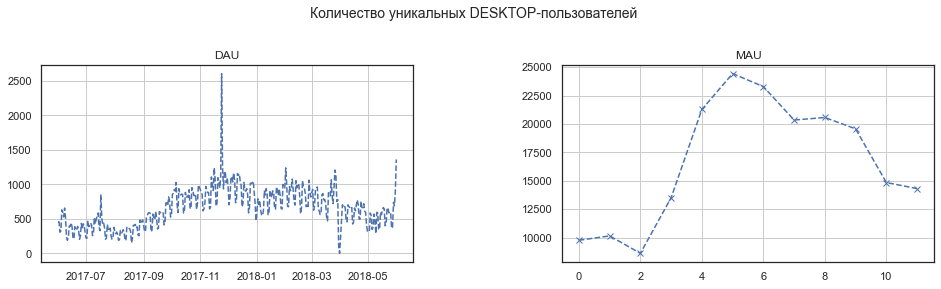

In [57]:
plt.figure(figsize=(16, 8))
plt.subplots_adjust(wspace = 0.4)
# Количество уникальных пользователей в день
plt.subplot(221)
plt.plot(dau_desktop, linestyle='--', marker='')
plt.title('DAU')
plt.grid(True)
plt.suptitle("Количество уникальных DESKTOP-пользователей", fontsize=14)

# Количество уникальных пользователей в месяц
plt.subplot(222)
plt.plot(mau_desktop.reset_index()['user_id'], linestyle='--', marker='x')
plt.title('MAU')
plt.grid(True)

#### TOUCH-пользователи

In [58]:
# для touch-пользователей
dau_touch = visits.query('device == "touch"').groupby('visit_date').agg({'user_id': 'nunique'})
wau_touch = visits.query('device == "touch"').groupby(['visit_year', 'visit_week']).agg({'user_id': 'nunique'})
mau_touch = visits.query('device == "touch"').groupby(['visit_year', 'visit_month']).agg({'user_id': 'nunique'})
print('Среднее количество уникальных пользователей устройств touch: \nв день (DAU) - {} человек, \n\
в неделю (WAU) - {} человек, \n\
в месяц (MAU) - {} человек.'.format(int(dau_touch.mean()), int(wau_touch.mean()), int(mau_touch.mean())))

Среднее количество уникальных пользователей устройств touch: 
в день (DAU) - 252 человек, 
в неделю (WAU) - 1634 человек, 
в месяц (MAU) - 6825 человек.


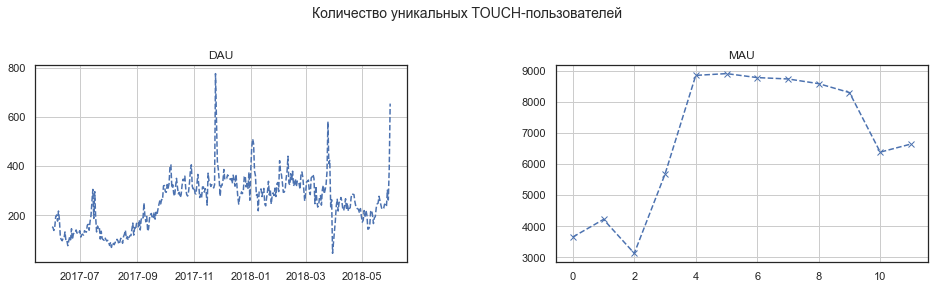

In [59]:
plt.figure(figsize=(16, 8))
plt.subplots_adjust(wspace = 0.4)
# Количество уникальных пользователей в день
plt.subplot(221)
plt.plot(dau_touch, linestyle='--', marker='')
plt.title('DAU')
plt.grid(True)
plt.suptitle("Количество уникальных TOUCH-пользователей", fontsize=14)

# Количество уникальных пользователей в месяц
plt.subplot(222)
plt.plot(mau_touch.reset_index()['user_id'], linestyle='--', marker='x')
plt.title('MAU')
plt.grid(True)

- количество посещений сильно выросло в период октябрь 2017 - март 2018;
- посещаемость desktop-пользователей в 2-3 раза выше touch-пользователей;
- за 24.11.2017 аномально большое количество уникальных пользователей, за 31.03.2018 аномально низкое количество уникальных пользователей (это тема для баг-репорта).

### 2.2 Средняя (медианная) длительность сессии для desktop и touch пользователей

Часто встречаются сессии длительностью меньше либо равно 60 секунд, но они составляют только ~25% от общего числа сессий, также в данных есть выбросы с очень долгими сессиями (порядка 23 часов), поэтому берем  медианное значение.


Средняя длительность сессии для пользователей desktop - 360 секунд, для touch - 180 секунд


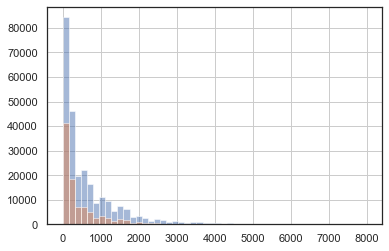

In [60]:
visits['duration_session'] = (visits['end_session'] - visits['start_session']).dt.seconds
visits.query('device == "desktop"')['duration_session'].hist(range=(0, 8000), bins=50, alpha=0.5)
visits.query('device == "touch"')['duration_session'].hist(range=(0, 8000), bins=50, alpha=0.5)

asl_desktop = visits.query('device == "desktop"')['duration_session'].median()
asl_touch = visits.query('device == "touch"')['duration_session'].median() 
print('Средняя длительность сессии для пользователей desktop - {} секунд, для touch - {} секунд'.format(int(asl_desktop), int(asl_touch)))

- из общего количества сессий в 359400, на долю desktop-пользователей приходится 262567 (73%), на долю touch-пользователей 96833 (27%);
- в среднем сессия desktop-пользователя длится около 6 мин, touch-пользователя 3 мин.

In [61]:
temp = visits.loc[:2].drop('duration_session', axis=1)
temp.columns = ['user_id', 'end_session', 'start_session', 'source_id', 'device',
                'visit_date', 'visit_week', 'visit_month', 'visit_year']
temp['duration_wrong'] = (temp['end_session'] - temp['start_session']).dt.seconds 
temp['duration_correct'] = pd.to_timedelta(temp['end_session'] - temp['start_session']).dt.total_seconds()
temp

,user_id,end_session,start_session,source_id,device,visit_date,visit_week,visit_month,visit_year,duration_wrong,duration_correct
0,16879256277535980062,2017-12-20 17:20:00,2017-12-20 17:38:00,4,touch,2017-12-20,51,12,2017,85320,-1080.0
1,104060357244891740,2018-02-19 16:53:00,2018-02-19 17:21:00,2,desktop,2018-02-19,8,2,2018,84720,-1680.0
2,7459035603376831527,2017-07-01 01:54:00,2017-07-01 01:54:00,5,touch,2017-07-01,26,7,2017,0,0.0


### Средняя (медианная) длительность сессии по месяцам

In [62]:
# здесь транспонируем для удобства визуального представления
visits.query('device == "desktop"').groupby(['visit_year', 'visit_month']).agg({'duration_session': 'median'}).round(2).T

visit_year       2017                               2018                    
visit_month        6    7    8    9    10   11   12   1    2    3    4    5 
duration_session  300  300  300  300  360  360  360  360  360  360  300  300

In [63]:
visits.query('device == "touch"').groupby(['visit_year', 'visit_month']).agg({'duration_session': 'median'}).round(2).T

visit_year       2017                               2018                    
visit_month        6    7    8    9    10   11   12   1    2    3    4    5 
duration_session  180  180  180  180  180  240  240  180  180  180  180  180

- видим, что от месяца к месяцу длительность сессии почти не изменяется для пользователей обоих видов устройств.

### 2.3 Коэффициенты "залипания" для desktop и touch пользователей

In [64]:
monthly_sticky_factor_desktop = dau_desktop.mean() / mau_desktop.mean()
monthly_sticky_factor_touch = dau_touch.mean() / mau_touch.mean()

print('Для desktop-пользователей {:.2%}, для touch-пользователей {:.2%}'.format(float(monthly_sticky_factor_desktop), float(monthly_sticky_factor_touch)))

Для desktop-пользователей 3.94%, для touch-пользователей 3.70%


- "залипают" примерно одинаково слабо для обоих видов устройств, в месяц возвращаются в 3.9% (desktop) и 3.7% (touch) случаях.

### 2.4 Retention Rate

In [65]:
# добавим дату первого посещения сайта
first_visit_date = visits.groupby('user_id')['start_session'].min()
first_visit_date.name = 'first_visit_date'
visits = visits.join(first_visit_date,on='user_id')

# добавим месяц первого посещения (по нему будут когорты)
visits['first_visit_month'] = visits['first_visit_date'].astype('datetime64[M]')

# добавим lifetime в месяцах
visits['cohort_lifetime'] = visits['start_session'] - visits['first_visit_date']
visits['cohort_lifetime'] = visits['cohort_lifetime'] / np.timedelta64(1,'M')
visits['cohort_lifetime'] = visits['cohort_lifetime'].round().astype('int')

# разобьем на когорты по месяцу первого посещения и периоду lifetime
cohorts = visits.groupby(['first_visit_month','cohort_lifetime']).agg({'user_id':'nunique'}).reset_index()

# посчитаем исходное количество пользователей в каждой когорте (на 0 lifetime)
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_visit_month', 'user_id']]
initial_users_count.columns = ['first_visit_month', 'cohort_users']

# добавим эти значения в когорты со всеми lifetime
cohorts = cohorts.merge(initial_users_count, on='first_visit_month')

# рассчитаем Retention Rate
cohorts['retention'] = (cohorts['user_id'] / cohorts['cohort_users']).round(2)

In [66]:
# преобразуем для красоты отображения осей в тепловой карте 
cohorts['first_visit_month'] = cohorts['first_visit_month'].dt.strftime('%Y-%m')

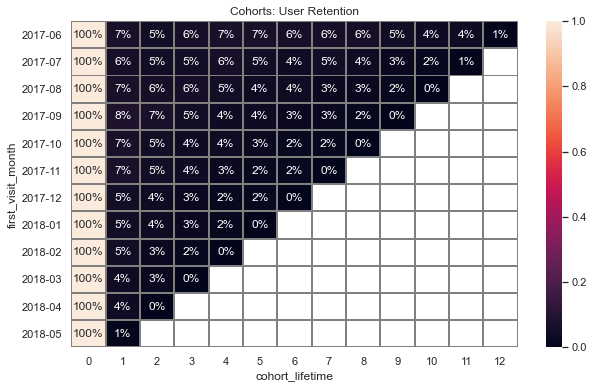

In [67]:
retention_pivot = cohorts.pivot_table(index='first_visit_month', columns='cohort_lifetime', values='retention')

plt.figure(figsize=(10, 6))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot, annot=True, fmt='.0%', linewidths=1, linecolor='gray');

- с удержанием пользователей беда, большая часть отваливается на первом месяце;
- может они и приходят, чтобы получить услугу и им больше незачем возвращаться (триггер рекламы сработал и этого достаточно).


### 2.4 Churn Rate (коэффициент оттока)

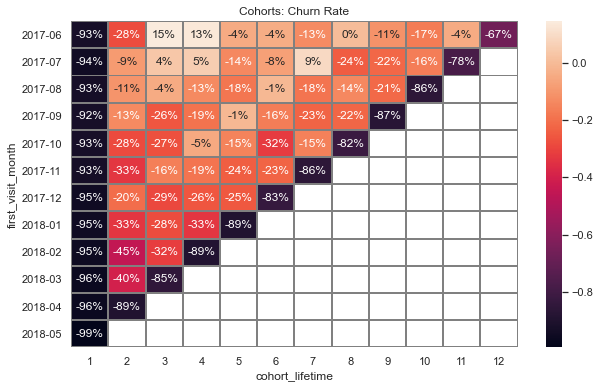

In [68]:
# рассчитаем процентное изменение числа пользователей от месяца к месяцу
cohorts['churn_rate'] = cohorts.groupby(['first_visit_month'])['user_id'].pct_change()
churn_pivot = cohorts.pivot_table(index='first_visit_month',columns='cohort_lifetime',values='churn_rate')
plt.figure(figsize=(10, 6))
plt.title('Cohorts: Churn Rate')
sns.heatmap(churn_pivot, annot=True, fmt='.0%', linewidths=1, linecolor='gray');

- отток пользователей в первый месяц в среднем 94%.

## 3. Основные метрики по продажам

### 3.1 Количество заказов в месяц, средняя выручка с заказа, cуммарная выручка в месяц.

In [69]:
# удалим единственное значение за 01 июня 2018 года и добавим месяц и год
orders = orders.drop(index=50414, axis=0) 
orders['order_month'] = orders['order_date'].dt.month
orders['order_year'] = orders['order_date'].dt.year 

cnt_orders  revenue_mean  revenue_sum
order_year order_month                                       
2017       6                  2354          4.06      9557.49
           7                  2363          5.31     12539.47
           8                  1807          4.85      8758.78
           9                  3387          5.42     18345.51
           10                 5679          4.93     27987.70
           11                 5659          4.78     27069.93
           12                 6218          5.85     36388.60
2018       1                  4721          4.11     19417.13
           2                  5281          4.84     25560.54
           3                  5326          5.41     28834.59
           4                  3273          5.15     16858.06
           5                  4346          4.77     20735.98

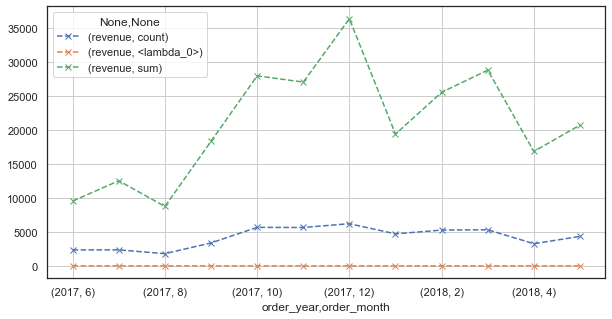

In [70]:
orders_per_month = orders.groupby(['order_year', 'order_month']).agg({'revenue': ['count', lambda x: round(np.mean(x), 2), 'sum']})
orders_per_month.plot(grid=True, figsize=(10, 5), linestyle='--', marker='x')
orders_per_month.columns = ['cnt_orders', 'revenue_mean', 'revenue_sum']
orders_per_month                   

- люди активно начинают покупать в октябре, количество заказов вырастает примерно в 2 раза с 2800 до 5600 заказов в месяц;
- при этом средний чек заказа от месяца к месяцу почти не меняется и составляет 4.96 рубля.

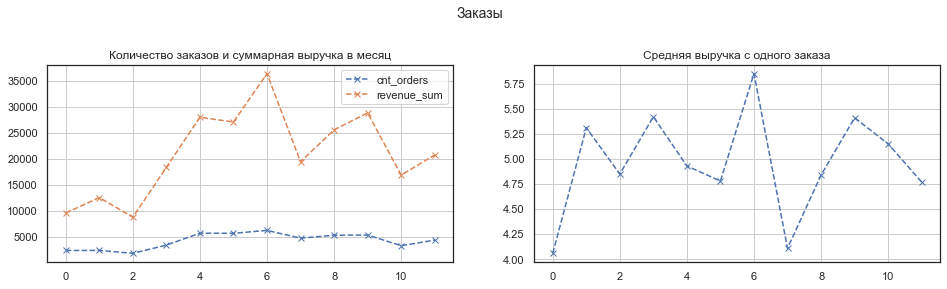

In [71]:
# ВАРИАНТ 1 с дополнительным графиком

orders_per_month_graph = orders_per_month.reset_index()
plt.figure(figsize=(16, 8))
plt.subplots_adjust(wspace = 0.2)
# Количество уникальных пользователей в день
plt.subplot(221)
plt.plot(orders_per_month_graph[['cnt_orders', 'revenue_sum']], linestyle='--', marker='x')
plt.title('Количество заказов и cуммарная выручка в месяц')
plt.grid(True)
plt.legend(['cnt_orders', 'revenue_sum'])
plt.suptitle("Заказы", fontsize=14)

# Количество уникальных пользователей в месяц
plt.subplot(222)
plt.plot(orders_per_month_graph['revenue_mean'], linestyle='--', marker='x')
plt.title('Средняя выручка с одного заказа')
plt.grid(True)

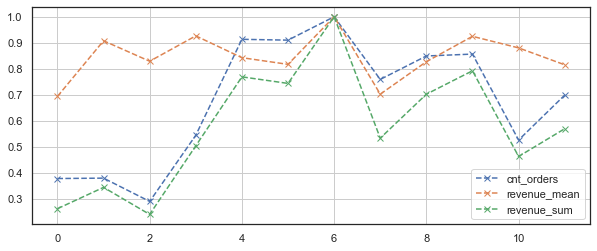

In [72]:
# ВАРИАНТ 2 с нормировкой на максимальное значение
def my_norm(s):
       return s/s.max()

orders_per_month_norm = orders_per_month_graph[['cnt_orders', 'revenue_mean', 'revenue_sum']].apply(my_norm, axis=0)
orders_per_month_norm.plot(figsize=(10,4), linestyle='--', marker='x', grid=True)

Корреляция между количеством заказов и выручкой в месяц:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


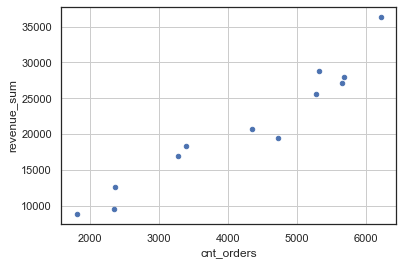

In [73]:
# посмотрим на корреляцию
orders_per_month.plot('cnt_orders', 'revenue_sum', grid=True, kind='scatter')

In [74]:
coef = orders_per_month['cnt_orders'].corr(orders_per_month['revenue_sum'])
print('Коэффициент корреляции между количеством заказов в месяц и выручкой в месяц {:.2f}'.format(coef))

Коэффициент корреляции между количеством заказов в месяц и выручкой в месяц 0.96


- выручка изменяется в соответствии с количеством заказов, коэффициент корреляции +0.96.

### 3.2 Ежемесячная конверсия визитов в заказы

In [29]:
# всего визитов за каждый месяц
visits_per_month = visits.groupby(['visit_year', 'visit_month']).agg({'user_id': 'count'}).reset_index()
visits_per_month.columns = ['visit_year', 'visit_month', 'cnt_visits']

# всего заказов за каждый месяц
orders_per_month = orders.groupby(['order_year', 'order_month']).agg({'user_id':'count'}).reset_index()
orders_per_month.columns = ['order_year', 'order_month', 'cnt_orders']

# конверсия за каждый месяц
result = pd.merge(visits_per_month, orders_per_month, left_on='visit_month', right_on='order_month')
result = result.drop(['order_year', 'order_month'], axis=1)
result.columns = ['year', 'month', 'cnt_visits', 'cnt_orders']
result['conversion_rate'] = (result['cnt_orders'] / result['cnt_visits']).round(2)
result

,year,month,cnt_visits,cnt_orders,conversion_rate
0,2017,6,16505,2354,0.14
1,2017,7,17828,2363,0.13
2,2017,8,14355,1807,0.13
3,2017,9,23907,3387,0.14
4,2017,10,37903,5679,0.15
5,2017,11,43969,5659,0.13
6,2017,12,41983,6218,0.15
7,2018,1,36939,4721,0.13
8,2018,2,37182,5281,0.14
9,2018,3,35679,5326,0.15


- конверсия в среднем составляет 14%, почти не меняется от месяца к месяцу;
- было бы здорово её увеличить в целом, а особенно в период октябрь-март, когда количество посетителей Яндекс.Афишы в 2 раза выше (дополнительные промокоды на этот период, запустить акции, рассылку или что там ещё маркетологи умеют:)

## 4. Основные метрики по маркетингу

### 4.1 Расходы на каждый рекламный источник

In [30]:
# на каждый источник потрачено
costs.groupby('source_id')['cost'].sum().sort_values(ascending=False)

source_id
3     141321.63
4      61073.60
5      51757.10
2      42806.04
1      20833.27
10      5822.49
9       5517.49
Name: cost, dtype: float64

- наибольшие затраты на рекламные источники №2-5;
- на источники №6-8 затрат нет вообще, все что с них придет, уже окупилось =);

### 4.2 Расходы на каждый рекламный источник за каждый месяц

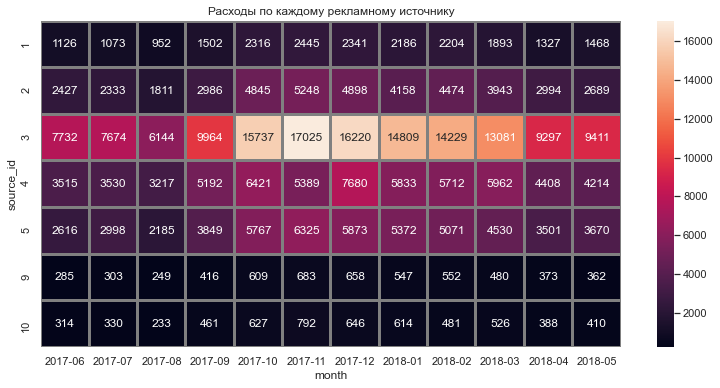

In [31]:
costs['month'] = costs['adv_date'].astype('datetime64[M]').dt.strftime('%Y-%m') 
costs_by_source = costs.pivot_table(
    index='source_id',
    columns='month',
    values='cost',
    aggfunc='sum'
)
plt.figure(figsize=(13, 6))
plt.title('Расходы по каждому рекламному источнику')
sns.heatmap(costs_by_source, annot=True, fmt='.0f', linewidths=2, linecolor='grey')

- опять же наибольшие затраты на рекламные источники №2-5;
- основные затраты по этим источникам состредочены в интервале октябрь 2017 - март 2018.

### 4.3 Показатели LTV, CAC, ROMI для каждого рекламного источника

#### Определение рекламного источника для каждого заказа
Тут логично было бы выбрать для каждого заказа тот рекламный источник, который совпадает по uid и времени начала сессии. Т.е. пользователь uid зашел на сайт и в период между start_session и end_session сделал заказ. Но в таблице orders много заказов, которые по времени не попадают в данный период и такие которые сделали заказ не заходя на сайт о_О (это тема для баг-репорта).

**Поэтому для каждого пользователя uid в заказах подвязан тот рекламный источник, который первый раз встречается для данного пользователя в visits. Считаем, что именно с первого источника пользователь узнал о сервисе и начал им пользоваться**.


In [32]:
# определим источник откуда пришел пользователь, как самый первый с которого он узнал о сервисе
first_visit_date = visits.groupby('user_id').agg({'start_session':'min'}).reset_index()

# в user_source храним инфу какой пользователь из какого источника пришел
user_source = pd.merge(visits, first_visit_date, on=['user_id', 'start_session'])

In [33]:
# добавим к каждому заказу рекламный источник из которого пришел пользователь и категорию его устройства
orders = orders.merge(user_source[['user_id', 'source_id', 'device']], on='user_id', how='left')

In [34]:
# добавим месяц первого заказа к каждому пользователю
first_order = orders.groupby('user_id').agg({'order_date': 'min'}).reset_index()
first_order['month'] = first_order['order_date'].astype('datetime64[M]')
first_order.columns = ['user_id', 'first_order_date', 'first_order_month']

orders = orders.merge(first_order[['user_id', 'first_order_month']], on='user_id')

# добавим месяц каждого заказа
orders['order_month'] = orders['order_date'].astype('datetime64[M]')

#### Количество заказов и уникальных пользователей из каждого рекламного источника

user_id           revenue
            count nunique       sum
source_id                          
1            5223    2899  31090.55
2            6392    3506  46923.61
3           13289   10473  54511.24
4           12894   10295  56693.41
5            9406    6931  52624.02
7               1       1      1.22
9            1647    1088   5759.40
10           1562    1329   4450.33

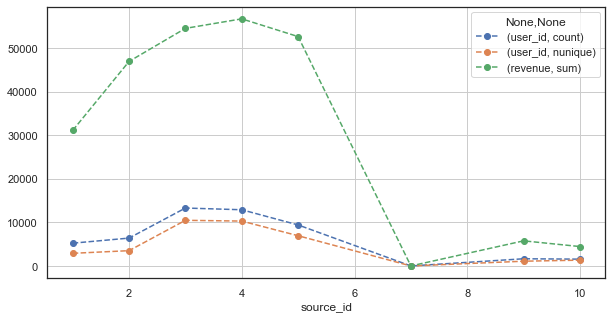

In [35]:
# количество заказов и уникальных пользователей из каждого источника 
temp = orders.groupby('source_id').agg({'user_id':['count', 'nunique'], 'revenue':'sum'})
temp.plot(grid=True, linestyle='--', marker='o', figsize=(10,5))
temp

- наибольшее количество заказов (user_id, count) и выручку (revenue, sum) принесли рекламные источники №2-5;

## Метрики в целом для всех рекламных источников


#### Расчет интегрального LTV по всем рекламным источникам


In [36]:
# создадим когорты по пxервому месяцу заказа
orders_grouped_by_cohorts = orders.groupby(['first_order_month','order_month']).agg({'revenue':'sum'})

# добавим lifetime каждой когорты
orders_grouped_by_cohorts = orders_grouped_by_cohorts.reset_index()
orders_grouped_by_cohorts['cohort_lifetime'] = orders_grouped_by_cohorts['order_month'] - orders_grouped_by_cohorts['first_order_month']
orders_grouped_by_cohorts['cohort_lifetime'] = orders_grouped_by_cohorts['cohort_lifetime'] / np.timedelta64(1,'M')
orders_grouped_by_cohorts['cohort_lifetime'] = orders_grouped_by_cohorts['cohort_lifetime'].round().astype('int')

# добавим численность когорты 
cohort_sizes = orders.groupby('first_order_month').agg({'user_id': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']

report = pd.merge(orders_grouped_by_cohorts, cohort_sizes, on='first_order_month')

# считаем LTV для каждой когорты за каждый месяц
report['ltv'] = report['revenue'] / report['n_buyers']

result = report.pivot_table(
        index='first_order_month', 
        columns='cohort_lifetime', 
        values='ltv', 
        aggfunc='mean').round(2)

result.cumsum(axis=1).round(2).fillna('')

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.72,5.21,5.65,6.6,7.62,8.36,9.31,9.89,10.44,11.05,11.62,11.88
2017-07-01,6.01,6.35,6.97,7.33,7.51,7.67,7.79,7.93,8.09,8.24,8.4,
2017-08-01,5.28,5.75,6.21,6.6,7.09,7.37,7.58,7.99,8.28,8.47,,
2017-09-01,5.64,6.76,7.28,11.26,11.66,12.31,13.01,13.25,13.43,,,
2017-10-01,5.00,5.54,5.73,5.89,6.04,6.16,6.24,6.36,,,,
2017-11-01,5.15,5.55,5.75,6.07,6.22,6.27,6.38,,,,,
2017-12-01,4.74,5,5.93,7,7.31,7.65,,,,,,
2018-01-01,4.14,4.43,4.73,4.87,4.93,,,,,,,
2018-02-01,4.16,4.44,4.52,4.59,,,,,,,,


#### Расчет интегрального CAC по всем рекламным источникам

In [37]:
# считаем суммарные расходы в месяц
costs['month'] = costs['adv_date'].astype('datetime64[M]')
costs_by_month = costs.groupby('month').agg({'cost':'sum'}).reset_index()

# считаем расходы на одного пользователя (CAC за каждый месяц)
report = pd.merge(report, costs_by_month, left_on='first_order_month', right_on='month')
report['cac'] = report['cost'] / report['n_buyers']

#### Расчет интегрального ROMI по всем рекламным источникам

In [38]:
report['romi'] = report['ltv'] / report['cac']

output = report.pivot_table(
          index='first_order_month',
          columns='cohort_lifetime',
          values='romi',
          aggfunc='mean').round(2)

# итоговая ROMI-таблица
output.cumsum(axis=1).round(2).fillna('')

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,0.53,0.58,0.63,0.74,0.85,0.93,1.04,1.11,1.17,1.24,1.3,1.33
2017-07-01,0.63,0.67,0.74,0.78,0.8,0.82,0.83,0.84,0.86,0.88,0.9,
2017-08-01,0.49,0.53,0.57,0.61,0.66,0.69,0.71,0.75,0.78,0.8,,
2017-09-01,0.60,0.72,0.78,1.2,1.24,1.31,1.38,1.41,1.43,,,
2017-10-01,0.60,0.66,0.68,0.7,0.72,0.73,0.74,0.75,,,,
2017-11-01,0.55,0.59,0.61,0.64,0.66,0.67,0.68,,,,,
2017-12-01,0.54,0.57,0.68,0.8,0.84,0.88,,,,,,
2018-01-01,0.42,0.45,0.48,0.49,0.5,,,,,,,
2018-02-01,0.46,0.49,0.5,0.51,,,,,,,,


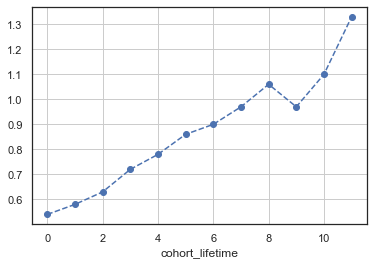

In [39]:
# средний ROMI по всем когортам за каждый месяц их жизни
romi_by_cohorts = output.cumsum(axis=1).mean(axis=0).round(2)
romi_by_cohorts.plot(grid=True, linestyle='--', marker='o')

- в целом расходы на рекламу окупились на девятый месяц, показатель ROMI на данный период составляет 1.06;
- далее смотрим детально на рентабельность каждого рекламного источника.

## Метрика ROMI для каждого рекламного источника по отдельности
Делая срез в таблицах `orders` и `costs` для каждого рекламного источника ROMI считается аналогичным образом. Итоговая таблица по каждому рекламному источнику:

In [40]:
romi_summary = pd.DataFrame({'cohort_lifetime': range(12),
                           'source_1': [0.89, 1.05, 1.26, 1.36, 1.56, 1.76, 2.04, 2.36, 2.86, 3.46, 4.26, 5.67],
                           'source_2': [0.55, 0.63, 0.78, 0.94, 1.09, 1.23, 1.03, 1.14, 1.22, 1.00, 1.30, 1.62],
                           'source_3': [0.34, 0.36, 0.37, 0.38, 0.40, 0.42, 0.43, 0.45, 0.47, 0.43, 0.48, 0.47],
                           'source_4': [0.76, 0.78, 0.79, 0.81, 0.84, 0.90, 0.98, 0.90, 0.90, 0.95, 1.16, 1.41],
                           'source_5': [0.66, 0.72, 0.78, 1.11, 1.23, 1.39, 1.55, 1.79, 2.02, 1.42, 1.31, 1.68],
                           'source_9': [0.77, 0.85, 0.94, 1.04, 1.08, 1.22, 1.33, 1.46, 1.56, 1.43, 1.43, np.nan],
                           'source_10':[0.73, 0.71, 0.76, 0.69, 0.74, 0.76, 0.88, 0.78, 0.61, 0.90, np.nan, np.nan]})

# переведем время жизни когорты в индекс для удобства построения графиков
romi_summary = romi_summary.set_index('cohort_lifetime')
romi_summary

,source_1,source_2,source_3,source_4,source_5,source_9,source_10
cohort_lifetime,,,,,,,
0,0.89,0.55,0.34,0.76,0.66,0.77,0.73
1,1.05,0.63,0.36,0.78,0.72,0.85,0.71
2,1.26,0.78,0.37,0.79,0.78,0.94,0.76
3,1.36,0.94,0.38,0.81,1.11,1.04,0.69
4,1.56,1.09,0.40,0.84,1.23,1.08,0.74
5,1.76,1.23,0.42,0.90,1.39,1.22,0.76
6,2.04,1.03,0.43,0.98,1.55,1.33,0.88
7,2.36,1.14,0.45,0.90,1.79,1.46,0.78
8,2.86,1.22,0.47,0.90,2.02,1.56,0.61


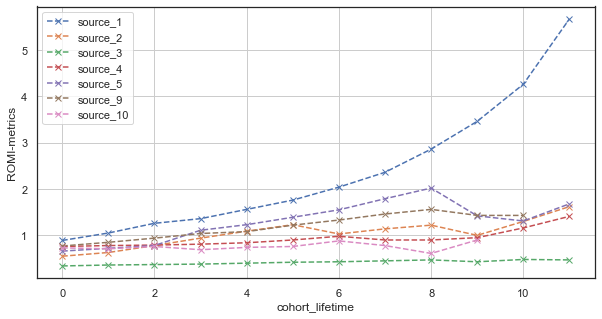

In [41]:
romi_summary.plot(figsize=(10,5), grid=True, linestyle='--', marker='x')
plt.ylabel('ROMI-metrics')
plt.show()

- по источнику №6 и №8 нет расходов и нет заказов ("нет ножек - нет мультиков" =)
- по источнику №7 нет расходов, но есть 1 заказ (это тема для баг-репорта);
- по остальным ниже в выводах.

- Добавил в функцию возможность передать аргументы в метод `plot` - `**kwargs` - и теперь легенда с указанием истончиков на месте

In [42]:
 def romi_calc(orders, costs, **kwargs):
    '''Calculate LTV, CAC, ROMI'''
    #LTV
    # создадим когорты по пxервому месяцу заказа
    orders_grouped_by_cohorts = orders.groupby(['first_order_month','order_month']).agg({'revenue':'sum'})

    # добавим lifetime каждой когорты
    orders_grouped_by_cohorts = orders_grouped_by_cohorts.reset_index()
    orders_grouped_by_cohorts['cohort_lifetime'] = orders_grouped_by_cohorts['order_month'] - orders_grouped_by_cohorts['first_order_month']
    orders_grouped_by_cohorts['cohort_lifetime'] = orders_grouped_by_cohorts['cohort_lifetime'] / np.timedelta64(1,'M')
    orders_grouped_by_cohorts['cohort_lifetime'] = orders_grouped_by_cohorts['cohort_lifetime'].round().astype('int')

    # добавим численность когорты 
    cohort_sizes = orders.groupby('first_order_month').agg({'user_id': 'nunique'}).reset_index()
    cohort_sizes.columns = ['first_order_month', 'n_buyers']

    report = pd.merge(orders_grouped_by_cohorts, cohort_sizes, on='first_order_month')

    # считаем LTV для каждой когорты за каждый месяц
    report['ltv'] = report['revenue'] / report['n_buyers']

    # CAC
    # считаем суммарные расходы в месяц
    costs['month'] = costs['adv_date'].astype('datetime64[M]')
    costs_by_month = costs.groupby('month').agg({'cost':'sum'}).reset_index()

    # считаем расходы на одного пользователя (CAC за каждый месяц)
    report = pd.merge(report, costs_by_month, left_on='first_order_month', right_on='month')
    report['cac'] = report['cost'] / report['n_buyers']

    #ROMI
    report['romi'] = report['ltv'] / report['cac']

    output = report.pivot_table(
              index='first_order_month',
              columns='cohort_lifetime',
              values='romi',
              aggfunc='mean').round(2)

    # средний ROMI по всем когортам за каждый месяц их жизни
    romi_by_cohorts = output.cumsum(axis=1).mean(axis=0).round(2)
    romi_plot = romi_by_cohorts.plot(grid=True, linestyle='--', marker='o', figsize=(10, 5), **kwargs)
    
    return romi_plot
    

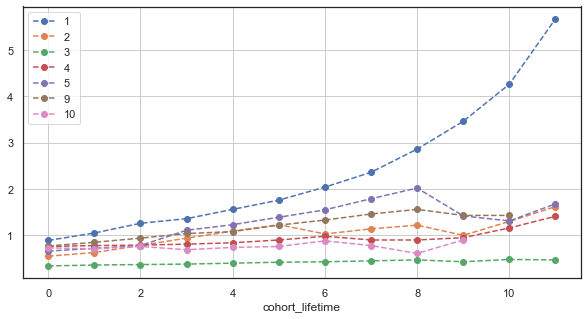

In [43]:
source_list = [1, 2, 3, 4, 5, 9, 10]
for source_id in source_list:
    romi_calc(orders[orders['source_id'] == source_id], costs[costs['source_id'] == source_id], label=source_id) 
plt.legend()

## 5. Выводы
_посещения сайта:_
- среди пользователей сайта преобладают desktop-пользователи, для них количество уникальных пользователей и количество сессий в 2-3 раза выше, чем у touch-пльзователей (659 против 252 DAU);
- с октября 2017 по март 2018 наблюдается значительный рост количества desktop-пользователей (с 10000 до 22000 MAU) и touch-пользователей (с 4000 до 9000 MAU). Скорее всего он связан с большими вложениями в рекламу за аналогичный период;
- в графиках DAU наблюдаются аномально большие значения за 24.11.2017 и аномально низкие за 31.03.2018;
- средняя длительность сессии для desktop-пользователей в два раза выше (6 мин), чем у touch-пользователей (3 мин). Это может быть связано, например, с тем, что интерфейс сайта для touch-пользователей неудобен или, наоборот, там сделать заказ проще и быстрее. Тут хорошо бы проверить гипотезу, что среднее время на оформления заказа touch-пльзователя меньше среднего времени на оформление заказа desktop-пользователем;
- и Retention rate, и Churn Rate говорят о том, что бОльшая часть пользователей ~95% не возвращаются. Возможно это связано с тем, что они увидили рекламу, зашли на сайт, сделали заказ, сходили на мероприятие и "забыли" о сервисе на несколько месяцев до следующей своей (или подкинутой рекламой:) идеи сходить куда-нибудь;

_продажи:_

- в продажах рост количества заказов с октября 2017 по март 2018 примерно в 2 раза (с 2800 до 5600 заказов в месяц), при этом средний чек заказа в течение года практически не меняется и составляет 4.96 руб. Соответственно коэффициент корреляции между количеством заказов в месяц и ежемесячной выручкой почти равен единице (+0.96);
- конверсия из посещений сайта в заказы также практически не меняется в течение года и составляет в среднем 14%, тут есть над чем поработать, ведь "легче удвоить конверсию, чем трафик";

_маркетинг:_

- в годовых расходах на рекламу преобладают рекламные источники №3, 4, 5, 2. При среднем расходе в 42000 рублей на них потрачено 141000, 61000, 52000, 43000 рублей соответственно;
- из тепловой карты видно, что основные расходы сосредоточены в периоде октябрь 2017 - март 2018 года, этим и объясняется значительный рост количества визитов и заказов за аналогичный период;
- в общем расходы на все рекламные источники окупились за девять месяцев (ROMI 1.06);
- при этом "не все ~~йогурты~~ источники одинаково полезны":
	- **наихудший результат** показал наибольший по затратам источник №3, он не окупился за анализируемый период (ROMI 0.47);
	- следующий по величине затрат рекламный источник №4 окупился только на 11 месяц (ROMI 1.16);
	- лучше него при сопостовимых затратах показал себя рекламный источник №5, он окупился уже на четвертый месяц (ROMI 1.11);
	- похожий результат для рекламного источника №2, на пятый месяц ROMI составлял 1.09;
	- **наилучший результат** для рекламного источника №1, он окупился уже на второй месяц (ROMI 1.05) и при этом в течение анализируемого год непрерывно рос, составив на 12 месяц ROMI 5.67, т.е. окупился более, чем в 5 раз;
	- из оставшихся двух рекламных источниках №9 и №10 (затраты 5500 и 5800 соответственно) источник №10 до сих пор не вернул затраченных на него средств, а источник №9 окупился на четвертый месяц (ROMI 1.04)

- таким образом с целью оптимизации маркетинговых затрат рекомендуется сократить расходы на источники №3, 4, 10, отдав предпочтения источникам №1, 2, 5, 9.
	

**Важное примечание:**

Показатель LTV положено считать из валовой прибыли, у нас только данные по выручке (по себестоимости или маржинальности данных нет). 
Поэтому все последующие расчеты сделаны по выручке (как будто маржинальность 100%). При снижении нормы маржи все сроки для окупаемости затрат увеличатся!!!